# Super Resolution

## 고해상도의 이미지를 저해상도로 변환하는 것은 쉽지만 
## 반대의 작업은 어려운 연산과정이 수행되어 집니다. 
## 픽셀은 디지털 이미지의 최소 단위입니다. 
---
---
## 픽셀로 구성된 이미지는 고해상도로 변환(확대)하면 
## 이미지에서 사각형이 두드러져 보이는, 소위 픽셀이 깨지는 현상이 일어나게 되는데, 
## 이를 자연스러운 고해상도 이미지로 만들어주는 것이 바로 
## Super Resolution 작업입니다. 

---
---
##전통적 알고리즘으로는 주변 값과 비슷한 값으로 보간하는 등의 기법이 있는데, 
## 이렇게 보간된 이미지는 선명함을 잃고 흐릿해지게 됩니다. 

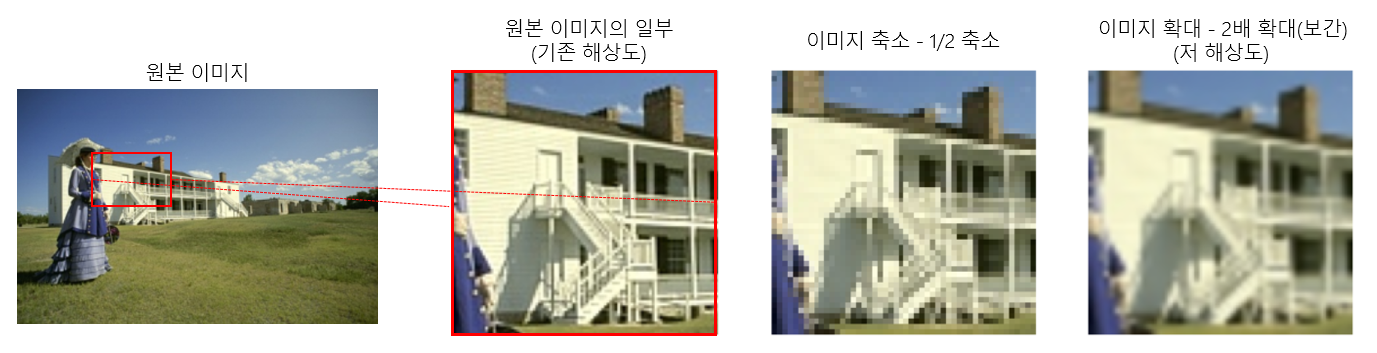

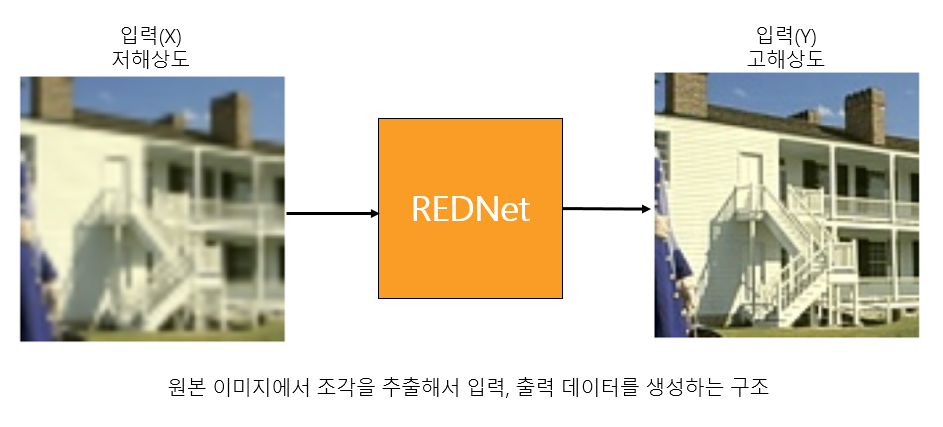

## 이전에 간단하게 살펴본 오토 인코더를 활용하여 
## 초해상도 작업을 하는 신경망을 학습할 수 있습니다. 

## 오토 인코더에서 파생된 수 많은 신경망 중에서 우린 REDNet 이라는 신경망을 
## 사용해보도록 하겠습니다. 

## REDNet은 Residual Encoder-Decoder Network의 약자로, 
## 인코더와 디코더는 오토인코더에서 이미 봤으니 넘어가고, 
## Residual은 ResNet 등에서 사용하는 skip-connection 입니다. 

## 다수의 레이어가 중첩되는 구조에서는 앞쪽의 정보를 잃어버리기 쉽습니다. 
## 그래서 앞쪽의 정보를 잃어보리지 않기 위해 뒤쪽에 정보를 그대로 전달해줄 때 
## skip-connection 이 사용되어 집니다. 





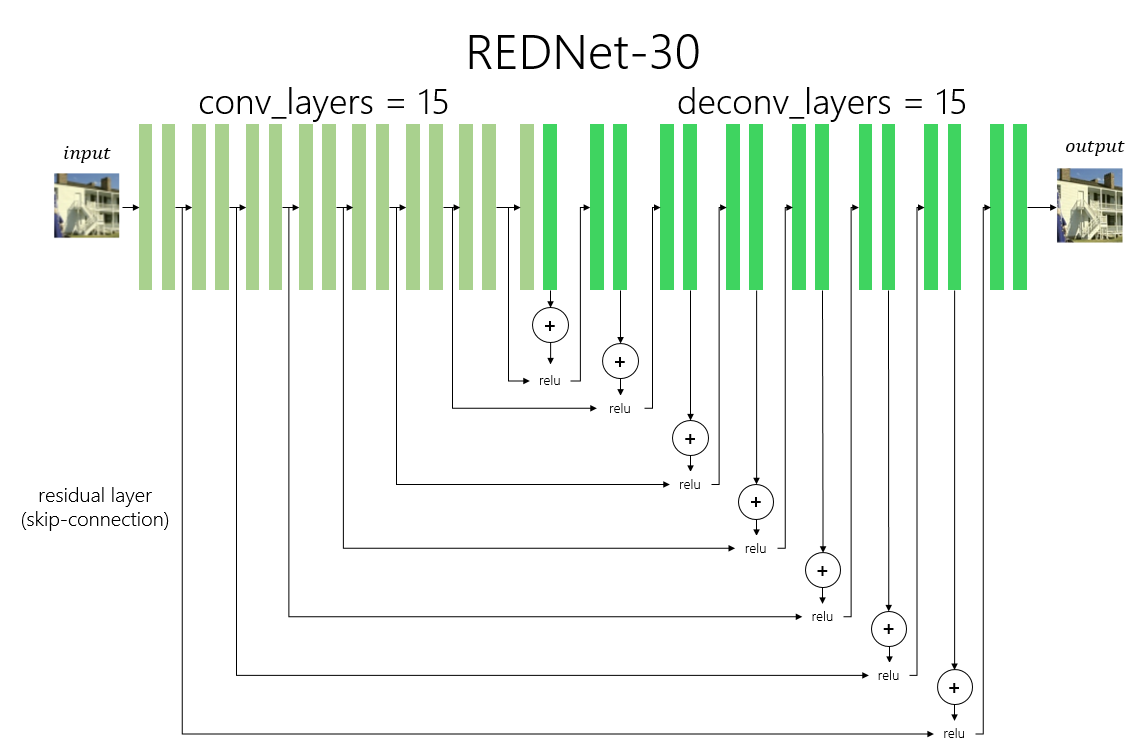

## REDNet에는 REDNet-10, REDNet-20, REDNet-30이 있는데, 
## 뒤의 숫자는 컨볼루션 레이어와 디컨볼루션 레이어를 합친 수 입니다. 
## REDNet-30은 15개의 컨볼루션 레이어와 15개의 디컨볼루션 레이어로 구성됩니다. 

## 입력과 출력, 그리고 그 사이에 존재하는 컨볼루션 레이어와 
## 디컨볼루션 레이어를 거치는 데이터의 크기는 모두 동일합니다. 
## 레이어를 많이 사용하기 때문에 앞쪽의 정보를 잃어버리지 않기 위해 
## 2개의 컨볼루션 혹은 디컨볼루션 레이어를 거칠 때마다 
## skip-connection을 사용합니다. 

## skip-connection은 합연산으로 계산되며, 
## tf.keras에서는 Add 레이어를 사용하면 됩니다. 

---
---

## 논문에서는 BSD(berkeley segmentation dataset)데이터 세트를 사용하였는데, 
## 우리 수업에서도 같은 데이터를 사용해주도록 하겠습니다. 


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib             # 파일들의 경로 설정을 위한 라이브러리  
import PIL.Image as Image  # 시각화를 위한 라이브러리들 
import matplotlib.pyplot as plt

In [ ]:
# BSD 데이터 셋을 받아오는 코드입니다.  
tf.keras.utils.get_file('/content/bsd_images.zip', 'http://bit.ly/35pHZlC', extract=True)

!unzip /content/bsd_images.zip

## 압축이 해제된 파일들을 저장하고, pathlib를 사용하여 
## 모든 이미지의 경로를 하나의 변수에 저장하여 주겠습니다.

In [ ]:
# 이미지가 저장된 폴더 경로를 변수화 해줍니다. 
image_root = pathlib.Path('/content/images')
print(image_root)

/content/images


In [ ]:
# 기존 변수에 glob('*/*') 코드를 사용하여 images 폴더 하위에 있는 모든 이미지 파일들을 
# 변수에 할당하여 줍니다.  
all_image_paths = list(image_root.glob('*/*'))
print("len(all_image_paths) : \n", len(all_image_paths))
print(all_image_paths[:10])

len(all_image_paths) : 
 503
[PosixPath('/content/images/train/78019.jpg'), PosixPath('/content/images/train/181079.jpg'), PosixPath('/content/images/train/187071.jpg'), PosixPath('/content/images/train/245051.jpg'), PosixPath('/content/images/train/188063.jpg'), PosixPath('/content/images/train/61086.jpg'), PosixPath('/content/images/train/157036.jpg'), PosixPath('/content/images/train/147021.jpg'), PosixPath('/content/images/train/8049.jpg'), PosixPath('/content/images/train/368078.jpg')]


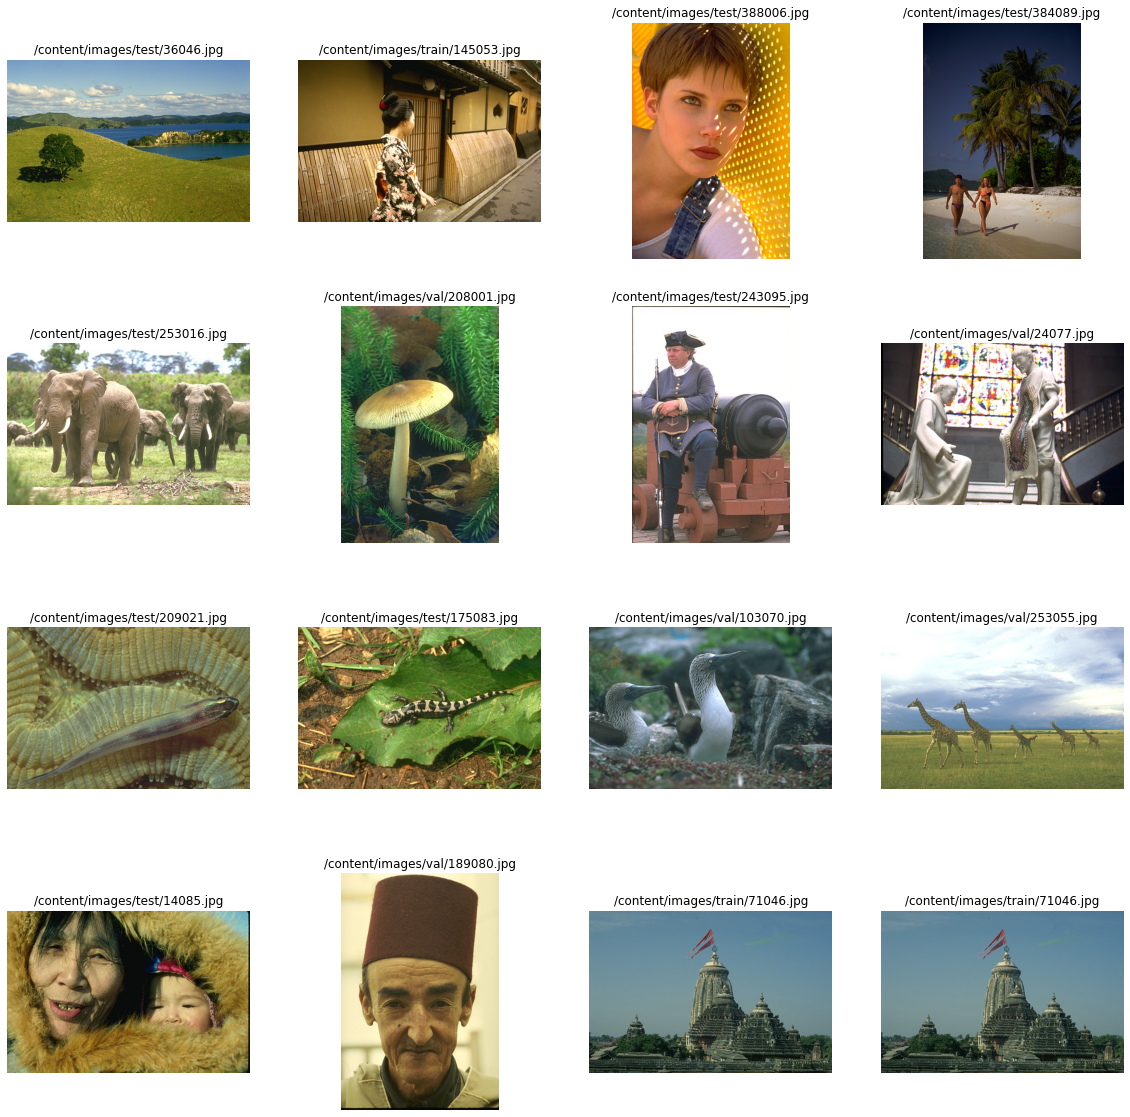

In [ ]:
plt.figure(figsize = (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    i = np.random.choice(502)
    # 위에서 변수화한 이미지를 한장 씩 가져오도록 합니다. 
    plt.imshow(plt.imread(all_image_paths[i]))
    plt.title(all_image_paths[i])
    plt.axis('off')

plt.show()

## 이미지의 가로 세로의 길이가 각각 다르며, 
## 이미지의 내용에는 사람, 동물, 사물 등 다양하다는 것을 
## 알 수 있습니다. 



## 다음은 데이터셋을 각각 분리하여 변수에 저장하는 과정을 수행하여 주겠습니다. 
## 우선 jpg 확장자를 가진 데이터임을 확인할 수 있었으며  
## 받아온 데이터는 학습 / 검증 / 테스트 데이터 이기에 이를 고려한 코드를 작성해주겠습니다.


In [ ]:
# 학습 / 검증 / 테스트 경로를 각각 저장할 빈 변수를 할당합니다. 
train_path, valid_path, test_path = [], [], []

for image_path in all_image_paths:
    # 우선 데이터의 대부분이 jpg 형식이기에 
    # jpg가 아니라면 넘어가도록 코드를 작성하겠습니다. 
    if str(image_path).split('.')[-1] != 'jpg':
        continue

    # 이제 조건문을 걸어서 '/'을 기준으로 
    # 뒤에서 두 번째 문자열 값이 어떠한지에 따라 
    # 학습/ 검증/ 테스트 폴더로 할당하여 주겠습니다. 

    if str(image_path).split('/')[-2] == 'train':
        train_path.append(str(image_path))
    elif str(image_path).split('/')[-2] == 'val':
        valid_path.append(str(image_path))
    else:
        test_path.append(str(image_path))

In [ ]:
print("train_path : ", train_path[:5])
print("valid_path : ", valid_path[:5])
print("test_path : ", test_path[:5])

train_path :  ['/content/images/train/78019.jpg', '/content/images/train/181079.jpg', '/content/images/train/187071.jpg', '/content/images/train/245051.jpg', '/content/images/train/188063.jpg']
valid_path :  ['/content/images/val/299086.jpg', '/content/images/val/108070.jpg', '/content/images/val/219090.jpg', '/content/images/val/89072.jpg', '/content/images/val/159008.jpg']
test_path :  ['/content/images/test/253092.jpg', '/content/images/test/306051.jpg', '/content/images/test/104055.jpg', '/content/images/test/41096.jpg', '/content/images/test/20069.jpg']


## super resolution은 해상도를 높이는 과정입니다. 
## 그렇기에 낮은 해상도를 갖는 이미지가 필요합니다. 
---
---
## 현재 가지고 있는 이미지는 고해상도이기 때문에 
## 이미지의 해상도를 일부러 낮추고 
## 원본과 함께 반환하는 함수를 만들어 주겠습니다.
---
---
## 또 학습 효율을 높이기 위해 이미지를 받아온 다음 
## 이미지에서 가로 × 세로 50픽셀의 작은 조각을 잘라서 
## 학습에 사용하겠습니다. 


## 저해상도의 이미지는 입력에 사용되고, 
## 고해상도의 이미지는 출력에 사용됩니다. 
## 우리가 공부하였던 오토인코더와 달리 이번에 사용되는 입력과 출력은 
## 완전히 같지는 않습니다. 
## 하지만 거의 비슷하기 때문에 이렇게 초해상도 이미지를 얻는 신경망도 
## 잘 학습되어 집니다. 

## 이 과정을 코드로 작성하고 후에 함수로 구축해주도록 하겠습니다.

In [ ]:
# TF의 이미지를 읽어오는 함수를 사용하여 줍니다. 
img = tf.io.read_file('/content/images/train/216053.jpg')
# JPEG로 인코딩 된 이미지를 uint8 타입으로 디코딩합니다.
img = tf.image.decode_jpeg(img, channels=3)
print(img.shape)
print(img)

(321, 481, 3)
tf.Tensor(
[[[ 31  52  83]
  [ 30  51  82]
  [ 31  52  83]
  ...
  [ 87 109 132]
  [ 85 107 130]
  [ 85 107 130]]

 [[ 31  52  83]
  [ 31  52  83]
  [ 31  52  83]
  ...
  [ 88 110 133]
  [ 85 107 130]
  [ 85 107 130]]

 [[ 32  53  84]
  [ 32  53  84]
  [ 33  54  85]
  ...
  [ 88 110 134]
  [ 86 108 132]
  [ 87 109 133]]

 ...

 [[ 62  72  20]
  [ 64  74  22]
  [ 51  59  10]
  ...
  [ 79  85  41]
  [ 72  78  34]
  [ 59  65  21]]

 [[ 74  84  34]
  [ 68  78  28]
  [ 62  70  23]
  ...
  [ 49  54  14]
  [ 36  40   3]
  [ 40  44   7]]

 [[ 49  57  16]
  [ 36  44   3]
  [ 48  56  15]
  ...
  [ 30  31   0]
  [ 33  33   5]
  [ 26  29   0]]], shape=(321, 481, 3), dtype=uint8)


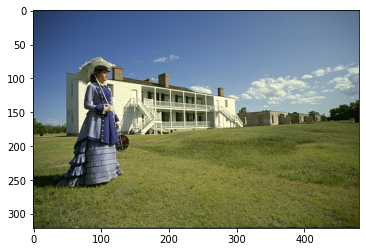

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
# 그리고 연산의 과정을 수월하게 진행하기 위해 데이터타입을 float32 형식으로 전환하고
# 이 함수의 특징은 min-max norm 과정을 함께 진행해줍니다. 
img = tf.image.convert_image_dtype(img, tf.float32)
print(img)

tf.Tensor(
[[[0.12156864 0.20392159 0.3254902 ]
  [0.11764707 0.20000002 0.32156864]
  [0.12156864 0.20392159 0.3254902 ]
  ...
  [0.34117648 0.427451   0.5176471 ]
  [0.33333334 0.41960788 0.50980395]
  [0.33333334 0.41960788 0.50980395]]

 [[0.12156864 0.20392159 0.3254902 ]
  [0.12156864 0.20392159 0.3254902 ]
  [0.12156864 0.20392159 0.3254902 ]
  ...
  [0.34509805 0.43137258 0.52156866]
  [0.33333334 0.41960788 0.50980395]
  [0.33333334 0.41960788 0.50980395]]

 [[0.1254902  0.20784315 0.32941177]
  [0.1254902  0.20784315 0.32941177]
  [0.12941177 0.21176472 0.33333334]
  ...
  [0.34509805 0.43137258 0.5254902 ]
  [0.3372549  0.42352945 0.5176471 ]
  [0.34117648 0.427451   0.52156866]]

 ...

 [[0.24313727 0.28235295 0.07843138]
  [0.2509804  0.2901961  0.08627451]
  [0.20000002 0.23137257 0.03921569]
  ...
  [0.30980393 0.33333334 0.16078432]
  [0.28235295 0.30588236 0.13333334]
  [0.23137257 0.25490198 0.08235294]]

 [[0.2901961  0.32941177 0.13333334]
  [0.26666668 0.30588236 0

In [ ]:
# 정규화처리가 되었는지 확인하는 과정입니다. 
np_img = np.asarray(img)
print("np_img.max() : ", np_img.max())
print("np_img.min() : ", np_img.min())

np_img.max() :  1.0
np_img.min() :  0.0


In [ ]:
# 고해상도 이미지를 저장하는 과정입니다. 
# 가로 × 세로 100픽셀 이미지를 random_crop() 함수로 얻어줍니다.  
hr = tf.image.random_crop(value = img, size = [100,100,3])
# 다음은 랜덤으로 얻어진 픽셀을 resize()를 통해 1/2 크기로 축소 합니다. 
lr_half = tf.image.resize(images = hr, size = [50,50])
# 그리고 이 이미지를 다시 확대시켜 사이즈는 갖게 유지하지만 
# 해상도는 낮게 설정하여 줍니다. 
lr = tf.image.resize(images = lr_half, size = [100,100])

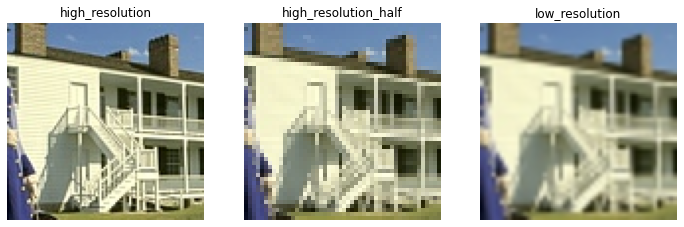

In [ ]:
# 위에서 얻은 이미지를 시각화하기 위한 과정입니다. 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('high_resolution')
plt.axis('off')
plt.imshow(hr)

plt.subplot(1, 3, 2)
plt.title('high_resolution_half')
plt.axis('off')
plt.imshow(lr_half)

plt.subplot(1, 3, 3)
plt.title('low_resolution')
plt.imshow(lr)
plt.axis('off')

plt.show()

# 이를 하나의 함수로 표현하기 위한 과정입니다. 

In [ ]:
def get_hr_and_lr(image_path):
    # TF의 이미지를 읽어오는 함수를 사용하여 줍니다. 
    img = tf.io.read_file(image_path)
    # JPEG로 인코딩 된 이미지를 uint8 타입으로 디코딩합니다.
    img = tf.image.decode_jpeg(img, channels=3)
    # 그리고 연산의 과정을 수월하게 진행하기 위해 float32 형식으로 전환하고
    # 이 함수의 특징은 min-max norm 과정을 함께 진행해줍니다. 
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 고해상도 이미지를 저장하는 과정입니다. 
    # 가로 × 세로 100픽셀 이미지를 random_crop() 함수로 얻어줍니다.  
    hr = tf.image.random_crop(value = img, size = [100,100,3])
    # 다음은 랜덤으로 얻어진 픽셀을 resize()를 통해 1/2 크기로 축소 합니다. 
    lr_half = tf.image.resize(images = hr, size = [50,50])
    # 그리고 이 이미지를 다시 확대시켜 사이즈는 갖게 유지하지만 
    # 해상도는 낮게 설정하여 줍니다. 
    lr = tf.image.resize(images = lr_half, size = [100,100])
    
    return lr, hr

# 다음은 데이터셋을 정의하는 과정입니다. 

In [ ]:
# train_path은 학습 데이터의 경로가 들어있는 변수입니다. 
# train_path에 저장된 경로를 데이터로 변환하는 과정입니다.  
train_dataset = tf.data.Dataset.list_files(file_pattern = train_path)

# dataset은 먼저 train_path 리스트의 이미지를 불러온 다음에 
# map()를 사용하여 get_hr_and_lr()를 적용시키고 
# 저해상도와 고해상도 조각인 lr,hr을 반환합니다. 
train_dataset = train_dataset.map(get_hr_and_lr)

# 반환되어진 값은 get_hr_and_lr() 함수를 통과한 lr, hr입니다. 
print(train_dataset)

<MapDataset shapes: ((100, 100, 3), (100, 100, 3)), types: (tf.float32, tf.float32)>


In [ ]:
# repeat()는 데이터를 반복적으로 사용하기 위한 함수, 
# batch(16)의 함수는 말 그래도 데이터의 배치 사이즈를 지정하기 위한 함수입니다.  
# 코드를 작성하고 출력된 결과를 보면 배치의 차원이 추가된 것을 
# 확인할 수 있습니다. 
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)
print(train_dataset)

<BatchDataset shapes: ((None, 100, 100, 3), (None, 100, 100, 3)), types: (tf.float32, tf.float32)>


In [ ]:
# 다음은 검증데이터 과정을 똑같이 수행하여 주고, 
# 이번에는 batch() 함수에 1을 주었습니다.  
valid_dataset = tf.data.Dataset.list_files(file_pattern = valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)
print(valid_dataset)

<BatchDataset shapes: ((None, 100, 100, 3), (None, 100, 100, 3)), types: (tf.float32, tf.float32)>


## 다음은 학습시킬 REDNet-30 모델을 정의하겠습니다. REDNet-30의 전체 구조는  
## 컨볼루션 레이어를 15개 쌓은 후 디컨볼루션 레이어를 15개 쌓는 단순한 구조입니다. 
## 그리고 각 레이어는 2칸씩 건너뛰면서 연결된 합연산이 relu 활성화 함수를 거쳐서 
## 다음 디컨볼루션 레이어로 연결되게끔 합니다. 

In [ ]:
# 우선 신경망의 레이어정보를 저장할 변수를 설정하고 인코더 부분만 먼저 정의하도록 하겠습니다. 

def REDNet(num_layers):

    global conv_layers, deconv_layers, residual_layers

    # 먼저 세 개의 빈 리스트에 각각 컨볼루션 레이어, 디컽볼루션 레이어, skip-connetion입니다. 
    # 레이어가 많고 서로 연산을 해야하기 때문에 각 레이어를 저장할 리스트를 따로 생성하여 주겠습니다.  
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    # 입력 계층을 정의합니다. 채널값만 3으로 강제 지정하고 나머지는 None으로 설정합니다. 
    # 어떠한 크기의 이미지라도 입력받을 수 있게 합니다. 
    inputs = tf.keras.layers.Input(shape=(None, None,3))

    # 다음은 첫 번째 컨볼루션 레이어와 마지막 디컨볼루션 레이어는 따로 정의하고, 
    # 이 외의 중간에 있는 레이어는 반복문을 통해 정의해주도록 하겠습니다. 

    # 첫 번째 컨볼루션 레이어를 정의합니다.
    # 이 과정에서 필터의 수, 커널 사이즈, 패딩, 활성화 함수등을 정의합니다. 
    conv_layers.append(tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, padding='same', activation='relu'))

    # 중간 과정의 '레이어 구축'을 진행하는 과정입니다. 
    # 활성화 함수를 relu, 필터의 수는 64장, 활성화 함수 relu를 설정합니다. 
    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(filters = 64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=3, padding='same', activation='relu'))
    
    # 마지막 디컨볼루션 레이어도 필터의 수는 3, 커널 사이즈도 3으로 설정하고
    # 활성화 함수는 따로 정의하지 않겠습니다. 
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=3, padding='same'))

    ##########################################################################################################

    # 인코더 시작 
    # 입력 레이어에 '첫 번째 컨볼루션 레이어'를 적용한 결과가 됩니다. 
    x = conv_layers[0](inputs)

    # 다음은 첫 번째 컨볼루션 레이어에 나머지 컨볼루션 레이어를 계속 적용시켜주는 과정입니다. 
    # num_layers = 15 
    for i in range(num_layers-1):

        # 다음번째 컨볼루션 레이어와 이전 컨볼루션 레이어를 연결시켜줍니다.  
        x = conv_layers[i+1](x)

        # 다음은 REDNet-30 처럼 짝수 텀 마다의 레이어마다의 결과를 
        # residual_layers 변수에 저장하여 줍니다. 
        if i % 2 == 0:
            residual_layers.append(x)

        # 이 과정까지의 결과를 표현하면 다음과 같습니다. 
        # inputs → 
        # 인코더 시작
        # conv_layers[0]  → conv_layers[1]  → residual_layers[0] → 
        # conv_layers[2]  → conv_layers[3]  → residual_layers[1] →
        # conv_layers[4]  → conv_layers[5]  → residual_layers[2] →
        # conv_layers[6]  → conv_layers[7]  → residual_layers[3] → 
        # conv_layers[8]  → conv_layers[9]  → residual_layers[4] →
        # conv_layers[10] → conv_layers[11] → residual_layers[5] →
        # conv_layers[12] → conv_layers[13] → residual_layers[6] → 
        # conv_layers[14] → 디코더 시작 

    # 여끼까지 정의하고 각 레이어의 정보를 확인해보도록 하겠습니다. 

In [ ]:
REDNet(15)
conv_layers

In [ ]:
deconv_layers

In [ ]:
residual_layers

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_46')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_48')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_50')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_52')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_54')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_56')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_58')>]

## 다음은 디코더까지 구축하는 과정을 코드로 구현해보도록 하겠습니다. 

In [ ]:
def REDNet(num_layers):

    # 전역변수는 삭제 

    # 먼저 세 개의 빈 리스트에 각각 컨볼루션 레이어, 디컽볼루션 레이어, skip-connetion입니다. 
    # 레이어가 많고 서로 연산을 해야하기 때문에 각 레이어를 저장할 리스트를 따로 생성하여 주겠습니다.  
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    # 입력 계층을 정의합니다. 채널값만 3으로 강제 지정하고 나머지는 None으로 설정합니다. 
    # 어떠한 크기의 이미지라도 입력받을 수 있게 합니다. 
    inputs = tf.keras.layers.Input(shape=(None, None,3))

    # 다음은 첫 번째 컨볼루션 레이어와 마지막 디컨볼루션 레이어는 따로 정의하고, 
    # 이 외의 중간에 있는 레이어는 반복문을 통해 정의해주도록 하겠습니다. 

    # 첫 번째 컨볼루션 레이어를 정의합니다.
    # 이 과정에서 필터의 수, 커널 사이즈, 패딩, 활성화 함수등을 정의합니다. 
    conv_layers.append(tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, padding='same', activation='relu'))

    # 중간 과정의 '레이어 구축'을 진행하는 과정입니다. 
    # 활성화 함수를 relu, 필터의 수는 64장, 활성화 함수 relu를 설정합니다. 
    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(filters = 64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=3, padding='same', activation='relu'))
    
    # 마지막 디컨볼루션 레이어도 필터의 수는 3, 커널 사이즈도 3으로 설정하고
    # 활성화 함수는 따로 정의하지 않겠습니다. 
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=3, padding='same'))

    ##########################################################################################################

    # 인코더 시작 
    # 입력 레이어에 '첫 번째 컨볼루션 레이어'를 적용한 결과가 됩니다. 
    x = conv_layers[0](inputs)

    # 다음은 첫 번째 컨볼루션 레이어에 나머지 컨볼루션 레이어를 계속 적용시켜주는 과정입니다. 
    # num_layers = 15 
    for i in range(num_layers-1):

        # 다음번째 컨볼루션 레이어와 이전 컨볼루션 레이어를 연결시켜줍니다.  
        x = conv_layers[i+1](x)

        # 다음은 REDNet-30 처럼 짝수 텀 마다의 레이어마다의 결과를 
        # residual_layers 변수에 저장하여 줍니다. 
        if i % 2 == 0:
            residual_layers.append(x)

        # 이 과정까지의 결과를 표현하면 다음과 같습니다. 
        # inputs → 
        # 인코더 시작
        # conv_layers[0]  → conv_layers[1]  → residual_layers[0] → 
        # conv_layers[2]  → conv_layers[3]  → residual_layers[1] →
        # conv_layers[4]  → conv_layers[5]  → residual_layers[2] →
        # conv_layers[6]  → conv_layers[7]  → residual_layers[3] → 
        # conv_layers[8]  → conv_layers[9]  → residual_layers[4] →
        # conv_layers[10] → conv_layers[11] → residual_layers[5] →
        # conv_layers[12] → conv_layers[13] → residual_layers[6] → 
        # conv_layers[14] → 디코더 시작 


    # 디코더 시작 
    # num_layers = 15
    for i in range(num_layers - 1):
        
        # 마찬가지로 REDNet-30의 디코더를 정의하는 과정입니다.   

        # 컨볼루션을 통과한 결과를 residual_layers과 결합하여 줍니다.
        # 이때 residual_layers의 마지막 계층부터 결합시켜주기 위해 pop()를 사용합니다.  

        # 그리고 활성화 함수 relu와 연결시켜 줍니다.  

        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        # 디코더 시작 
        # deconv_layers[i] //       if i % 2 == 1       // deconv_layers[i]
        # --------------------------------------------------------------------
        # deconv_layers[0] + residual_layers[6] → relu → deconv_layers[1] →
        # deconv_layers[2] + residual_layers[5] → relu → deconv_layers[3] →
        # deconv_layers[4] + residual_layers[4] → relu → deconv_layers[5] →
        # deconv_layers[6] + residual_layers[3] → relu → deconv_layers[7] →
        # deconv_layers[8] + residual_layers[2] → relu → deconv_layers[9] →   
        # deconv_layers[10] + residual_layers[1] → relu → deconv_layers[11] →
        # deconv_layers[12] + residual_layers[0] → relu → deconv_layers[13] →             

        # deconv_layers[14] → output

        # REDNet-30의 디코더 부분은 디컨볼루션 레이어가 먼저 하나가 붙습니다.  

        # 위 조건문의 i 값이 0인 경우는 실행되지 않으므로 
        # i 값이 1인 경우부터 실행되기에 
        #  첫 번째 디컨볼루션 레이어를 구축 과정 그리고 relu 이후의 디컨볼루션 레이어가
        # 연결되는 코드를 생성하여 줍니다.   

        x = deconv_layers[i](x)

    # 마찬가지로 마지막 블록의 디컨볼루션 레이어 구축 과정입니다. 
    x = deconv_layers[-1](x)

    # 지금까지 구축한 레이어를 모아주는 과정입니다. 
    model = tf.keras.Model(inputs = inputs, outputs = x)

    return model

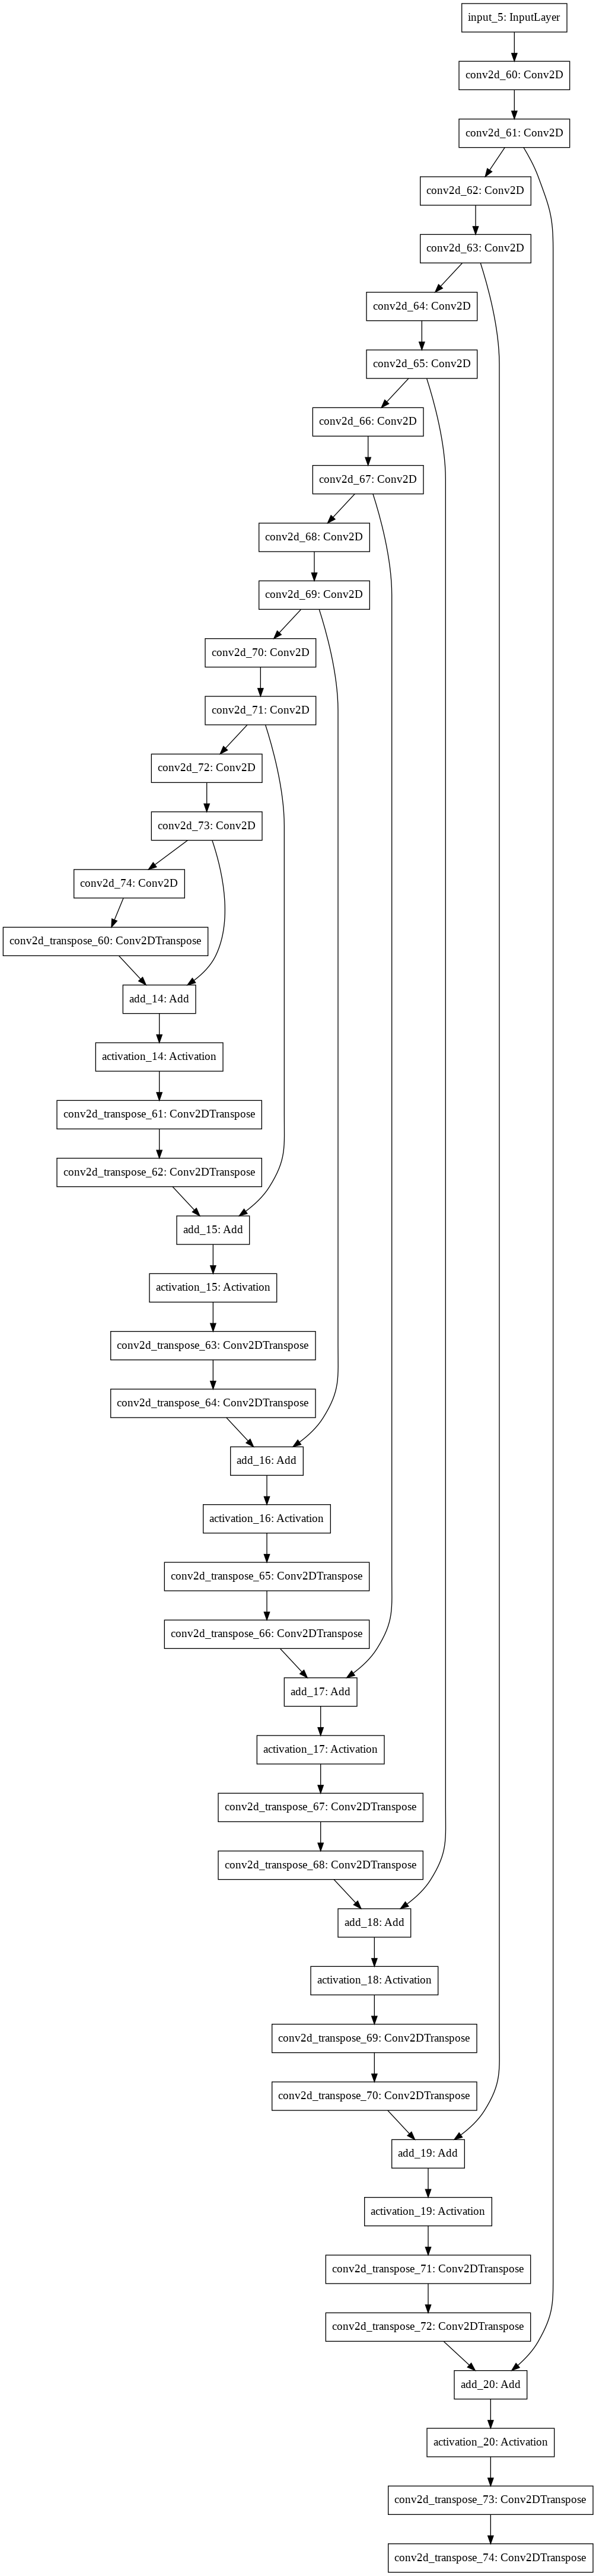

In [ ]:
# 지금까지 정의한 모델의 정보를 확인해보도록 하겠습니다. 
model = REDNet(num_layers=15)
tf.keras.utils.plot_model(model)

## 이제 학습을 위한 과정을 진행하도록 하겠습니다. 
## 그런데 우리가 생성한 신경망은 오토인코더 타입의 신경망 이며, 
## 학습이 잘 되었는지 확인이 필요합니다. 

---
---

## 여기서 사용되어지는 측정값은 PSNR(Peak Signal-to-Noise Ratio)입니다. 
## 이는 '신호 대 잡음비'로 원본 이미지와 재구성된 이미지의 PSNR을 계산하면 
## 이미지의 품질이 얼마나 좋은지를 측정할 수 있습니다. 
---
---
## 동일한 2개의 이미지를 PSNR로 계산하면 무한대의 값이 나오고, 
## 보통 30 이상이면 좋은 값이라고 간주합니다. 

# $$ PSNR = 20 \log_{10} \frac{Max(pixel)}{\sqrt{MSE}} $$

## 여기서 max(pixel)은 픽셀의 최댓값으로, 앞에서 min-max norm 을 진행하였기에 
## 최대값은 1.0 이 되어집니다.
## 그리고 mse는 우리가 잘 알고있는 평균 제곱 오차 입니다. 
## 하지만 이 값 자체가 log의 분모에 있기에 평균 제곱 오차가 낮을 수록 
## PSRN값은 큰 값을 갖게 됩니다. 

## 그렇기에 동일한 2개의 이미지를 계산하면 무한대의 값을 갖게 되는것이죠. 

In [ ]:
# 텐서플로우에서는 이 과정이 이미 함수로 존재하기에 이것을 
# 사용하도록 하겠습니다. 
# 마찬가지로 max_val 의 값은 1로 설정하여 줍니다. 

# y_true 값으로는 정답에 해당하는 값
# y_pred 값으로는 신경망이 학습 후 예측한 값입니다. 
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val = 1.0)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss = 'mse', metrics = [psnr_metric])

In [ ]:
history = model.fit_generator(train_dataset,
                              epochs = 1000,
                              # Dataset에 repeat() 함수를 사용했기 때문에 한 번의 에포크에 
                              # 몇 개의 데이터를 학습시킬지 결정하는 steps_per_epoch 인수를 설정해야 합니다. 
                              # 훈련 데이터의 경우 batch_size를 16으로 하였기에
                              # 전체 학습 데이터를 16으로 나눈 수 만큼을 설정합니다.   
                              steps_per_epoch  = len(train_path)//16,
                              # 검증 데이터를 설정하는 과정입니다. 
                              validation_data  = valid_dataset,
                              # 검증 데이터를 설정할 때는 전체 검증 데이터를 한번에 처리할 수 있도록 합니다. 
                              validation_steps = len(valid_path),
                              # 너무 많은 출력 결과를 보여주는 것 대신 출력 제한을 걸어주겠습니다. 
                              verbose = 2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
12/12 - 5s - loss: 0.1750 - psnr_metric: 8.4367 - val_loss: 0.0788 - val_psnr_metric: 12.1009
Epoch 2/1000
12/12 - 3s - loss: 0.0483 - psnr_metric: 14.6368 - val_loss: 0.0217 - val_psnr_metric: 17.2802
Epoch 3/1000
12/12 - 3s - loss: 0.0248 - psnr_metric: 16.8441 - val_loss: 0.0199 - val_psnr_metric: 17.8758
Epoch 4/1000
12/12 - 3s - loss: 0.0194 - psnr_metric: 17.9456 - val_loss: 0.0158 - val_psnr_metric: 18.6290
Epoch 5/1000
12/12 - 3s - loss: 0.0182 - psnr_metric: 18.3109 - val_loss: 0.0141 - val_psnr_metric: 19.2181
Epoch 6/1000
12/12 - 3s - loss: 0.0164 - psnr_metric: 18.7076 - val_loss: 0.0138 - val_psnr_metric: 19.5193
Epoch 7/1000
12/12 - 3s - loss: 0.0138 - psnr_metric: 19.5164 - val_loss: 0.0117 - val_psnr_metric: 20.2426
Epoch 8/1000
12/12 - 3s - loss: 0.0127 - psnr_metric: 19.8399 - val_loss: 0.0113 - val_psnr_metric: 20.3573
Epoch 9/1000
12/12 - 3s - loss: 0.0120 - psnr_metric: 20.3393 - val_loss: 0.0099 - val_psnr_metric: 21.0965
Epoch 10/1000
12/12 - 3s - lo

## 학습한 결과를 시각화하는 과정입니다. 

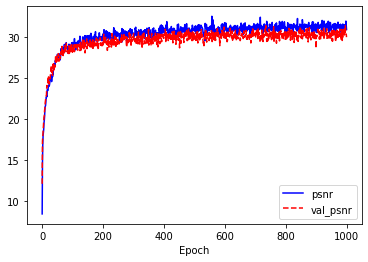

In [ ]:
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.save('REDNet-30.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


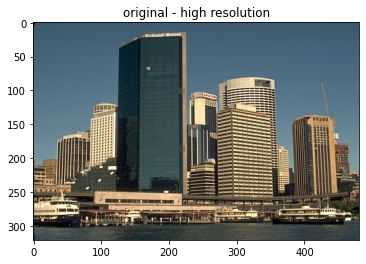

In [ ]:
# 테스트 데이터 이미지 출력
i = np.random.choice(100)
img = tf.io.read_file(test_path[i])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)
plt.title('original - high resolution')
plt.show()

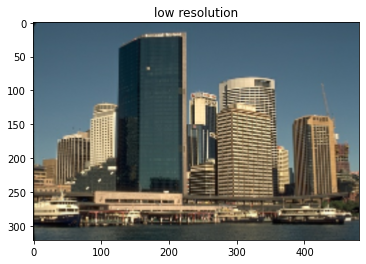

In [ ]:
# 이미지를 리사이징 하는 과정입니다. 
# 기존 이미지를 절반으로 줄이는 과정입니다. 
lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
# 절반으로 줄어든 이미지를 다시 원본크기로 키워주겠습니다. 
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])

plt.imshow(lr)
plt.title('low resolution')
plt.show()

In [ ]:
# 배치 차원을 추가하여 예측을 수행하여 줍니다. 
predict_hr = model.predict(np.expand_dims(lr, axis=0))

# 예측 사진과 실제 사진과의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))

# 낮은 해상도의 사진, 실제 해상도의 사진 사이의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(21.084675, shape=(), dtype=float32)
tf.Tensor(20.958542, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sr')

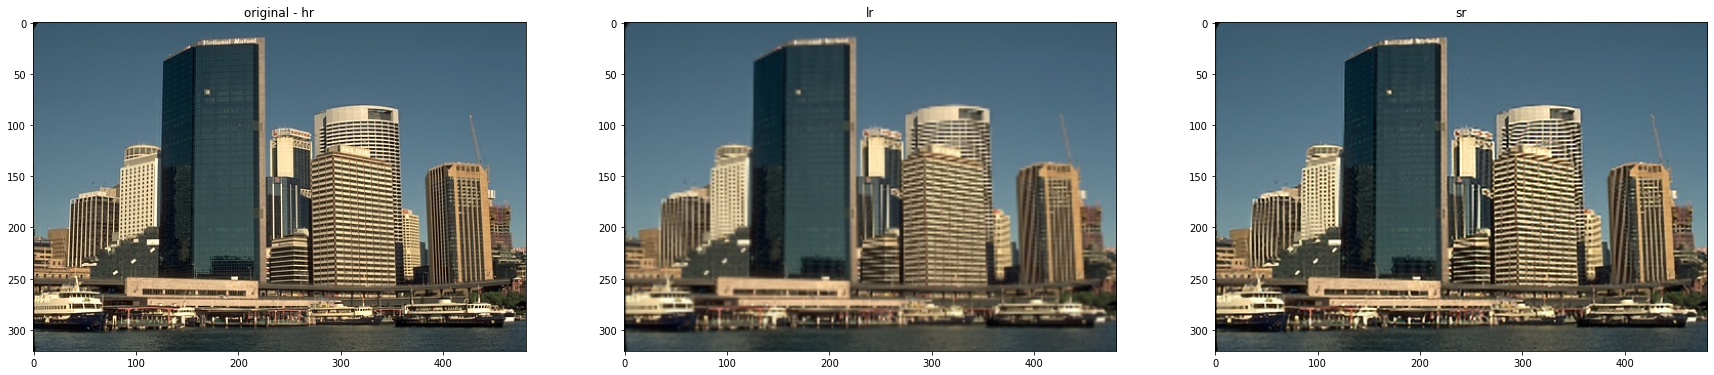

In [ ]:
plt.figure(figsize=(30,30))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

# 저장한 모델을 불러와 다시 테스트하는 과정입니다. 

In [ ]:
model_rednet_30 = tf.keras.models.load_model('/content/REDNet-30.h5', compile = False)

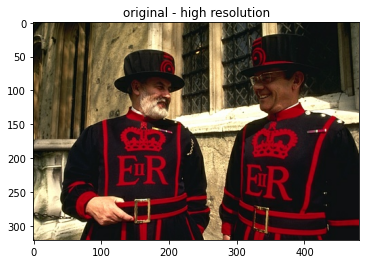

In [ ]:
# 테스트 데이터 이미지 출력
i = np.random.choice(100)
img = tf.io.read_file(test_path[i])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)
plt.title('original - high resolution')
plt.show()

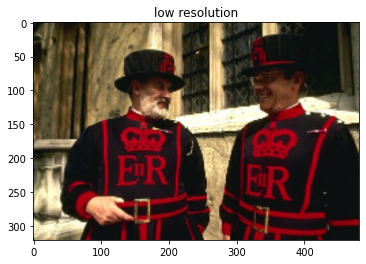

In [ ]:
# 이미지를 리사이징 하는 과정입니다. 
# 기존 이미지를 절반으로 줄이는 과정입니다. 
lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
# 절반으로 줄어든 이미지를 다시 원본크기로 키워주겠습니다. 
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])

plt.imshow(lr)
plt.title('low resolution')
plt.show()

In [ ]:
# 배치 차원을 추가하여 예측을 수행하여 줍니다. 
predict_hr = model_rednet_30.predict(np.expand_dims(lr, axis=0))

# 예측 사진과 실제 사진과의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))

# 낮은 해상도의 사진, 실제 해상도의 사진 사이의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(28.074293, shape=(), dtype=float32)
tf.Tensor(27.343056, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sr')

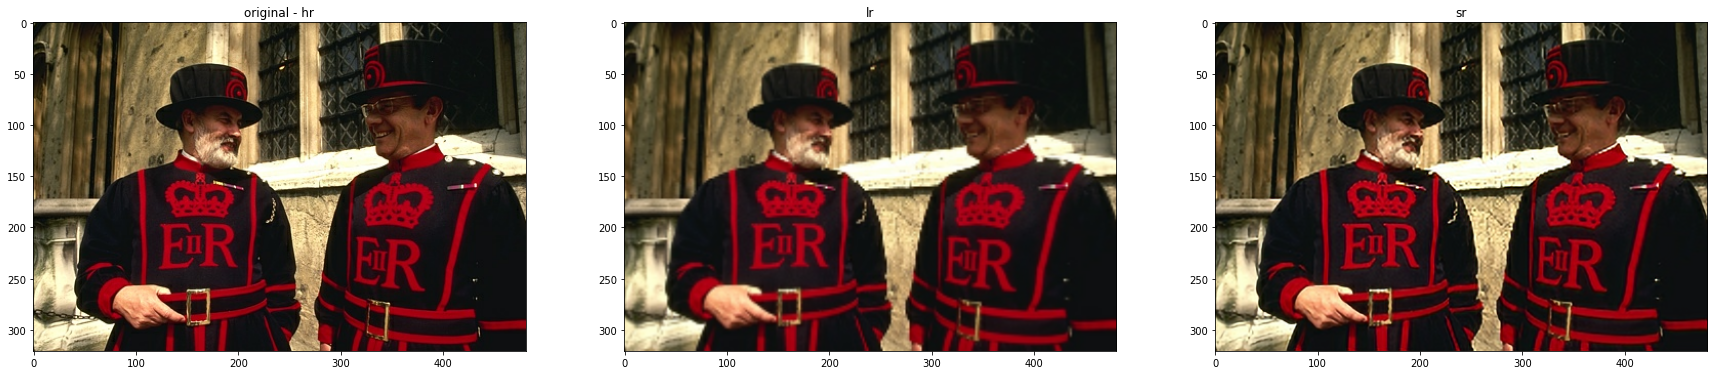

In [ ]:
plt.figure(figsize=(30,30))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

# 좀 더 높은 해상도 증가를 위한 과정 
## 현재는 실험을 위해 2배정도 낮은 해상도 이미지를 만들어 주었지만, 
## 이번에는 4배 더 낮은 해상도 이미지를 생성하여 주겠습니다. 

---
---

## 그리고 신경망의 성능을 높이기 위해 이미지 보강, 에폭수의 증가를 
## 함께 수행하여 주겠습니다. 
## 이전에 작성해둔 함수를 재정의해주도록 하겠습니다. 

In [ ]:
img = tf.io.read_file('/content/images/train/67079.jpg')
# JPEG로 인코딩 된 이미지를 uint8 타입으로 디코딩합니다.
img = tf.image.decode_jpeg(img, channels=3)
# 그리고 연산의 과정을 수월하게 진행하기 위해 float32 형식으로 전환하고
# 이 함수의 특징은 min-max norm 과정을 함께 진행해줍니다. 
img = tf.image.convert_image_dtype(img, tf.float32)

# 고해상도 이미지를 저장하는 과정입니다. 
# 가로 × 세로 100픽셀 이미지를 random_crop() 함수로 얻어줍니다.  
hr = tf.image.random_crop(value = img, size = [100,100,3])
# 다음은 랜덤으로 얻어진 픽셀을 resize()를 통해 1/4 크기로 축소 합니다. 
lr_half = tf.image.resize(images = hr, size = [25,25])
# 그리고 이 이미지를 다시 확대시켜 사이즈는 갖게 유지하지만 
# 해상도는 낮게 설정하여 줍니다. 
lr = tf.image.resize(images = lr_half, size = [100,100])

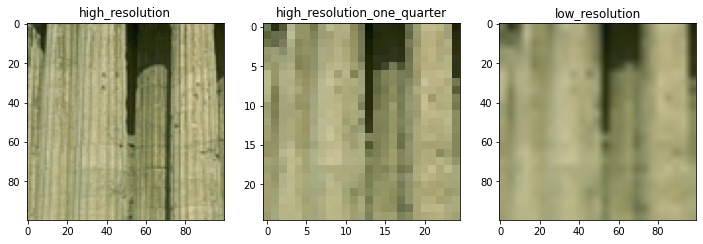

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('high_resolution')
plt.imshow(hr)

plt.subplot(1, 3, 2)
plt.title('high_resolution_one_quarter')
plt.imshow(lr_half)

plt.subplot(1, 3, 3)
plt.title('low_resolution')
plt.imshow(lr)

plt.show()

In [ ]:
import random

def get_hr_and_lr_s4(image_path):
    # TF의 이미지를 읽어오는 함수를 사용하여 줍니다. 
    img = tf.io.read_file(image_path)
    # JPEG로 인코딩 된 이미지를 uint8 타입으로 디코딩합니다.
    img = tf.image.decode_jpeg(img, channels=3)
    # 그리고 연산의 과정을 수월하게 진행하기 위해 float32 형식으로 전환하고
    # 이 함수의 특징은 min-max norm 과정을 함께 진행해줍니다. 
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 고해상도 이미지를 저장하는 과정입니다. 
    # 가로 × 세로 100픽셀 이미지를 random_crop() 함수로 얻어줍니다.  
    hr = tf.image.random_crop(value = img, size = [100,100,3])
    # 다음은 랜덤으로 얻어진 픽셀을 resize()를 통해 1/4 크기로 축소 합니다. 
    lr_half = tf.image.resize(images = hr, size = [25,25])
    # 그리고 이 이미지를 다시 확대시켜 사이즈는 갖게 유지하지만 
    # 해상도는 낮게 설정하여 줍니다. 
    lr = tf.image.resize(images = lr_half, size = [100,100])
    
    # 25%의 확률로 좌우 반전
    if random.random() < 0.25:
        hr = tf.image.flip_left_right(hr)
        lr = tf.image.flip_left_right(lr)

    # 25%의 확률로 상하 반전을 시켜줍니다. 
    # 결과적으로 훈련 데이터를 4배정도 늘려주는 효과를 주게 됩니다. 
    if random.random() < 0.25:
        hr = tf.image.flip_up_down(hr)
        lr = tf.image.flip_up_down(lr)

    return lr, hr

In [ ]:
# train_path은 학습 데이터의 경로가 들어있는 변수입니다. 
# train_path에 저장된 경로를 데이터로 변환하는 과정입니다.  
train_dataset = tf.data.Dataset.list_files(file_pattern = train_path)

# dataset은 먼저 train_path 리스트의 이미지를 불러온 다음에 
# map()를 사용하여 get_hr_and_lr()를 적용시키고 
# 저해상도와 고해상도 조각인 lr,hr을 반환합니다. 
train_dataset = train_dataset.map(get_hr_and_lr_s4)

# 반복처리와 배치처리를 수행하여 줍니다. 
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

In [ ]:
# 다음은 검증데이터 과정을 똑같이 수행하여 주고, 
# 이번에도 batch() 함수에 1을 주었습니다.  
valid_dataset = tf.data.Dataset.list_files(file_pattern = valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr_s4)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

In [ ]:
model = REDNet(num_layers=15)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss = 'mse', metrics = [psnr_metric])

In [ ]:
history = model.fit_generator(train_dataset,
                              epochs = 4000,
                              # Dataset에 repeat() 함수를 사용했기 때문에 한 번의 에포크에 
                              # 몇 개의 데이터를 학습시킬지 결정하는 steps_per_epoch 인수를 설정해야 합니다. 
                              # 훈련 데이터의 경우 batch_size를 16으로 하였기에
                              # 전체 학습 데이터를 16으로 나눈 수 만큼을 설정합니다.   
                              steps_per_epoch  = len(train_path)//16,
                              # 검증 데이터를 설정하는 과정입니다. 
                              validation_data  = valid_dataset,
                              # 검증 데이터를 설정할 때는 전체 검증 데이터를 한번에 처리할 수 있도록 합니다. 
                              validation_steps = len(valid_path),
                              # 너무 많은 출력 결과를 보여주는 것 대신 출력 제한을 걸어주겠습니다. 
                              verbose = 2)

In [ ]:
model.save('rednet-30-s4.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


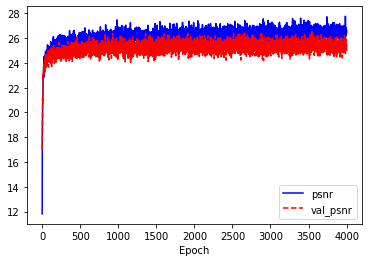

In [ ]:
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

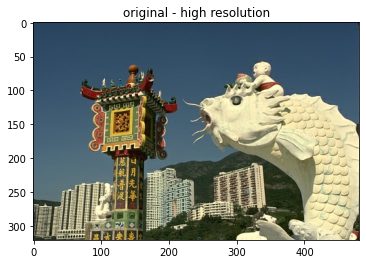

In [ ]:
# 테스트 데이터 이미지 출력
i = np.random.choice(100)
img = tf.io.read_file(test_path[i])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)
plt.title('original - high resolution')
plt.show()

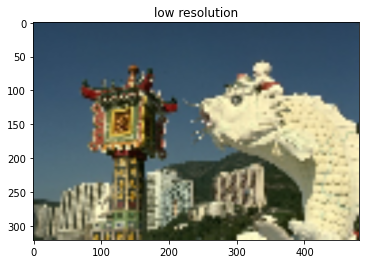

In [ ]:
# 이미지를 리사이징 하는 과정입니다. 
# 기존 이미지를 1/4로 줄이는 과정입니다. 
lr = tf.image.resize(hr, [hr.shape[0]//4, hr.shape[1]//4])
# 절반으로 줄어든 이미지를 다시 원본크기로 키워주겠습니다. 
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])

plt.imshow(lr)
plt.title('low resolution')
plt.show()

In [ ]:
# 배치 차원을 추가하여 예측을 수행하여 줍니다. 
predict_hr = model.predict(np.expand_dims(lr, axis=0))

# 예측 사진과 실제 사진과의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))

# 낮은 해상도의 사진, 실제 해상도의 사진 사이의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(20.17638, shape=(), dtype=float32)
tf.Tensor(19.778595, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sr')

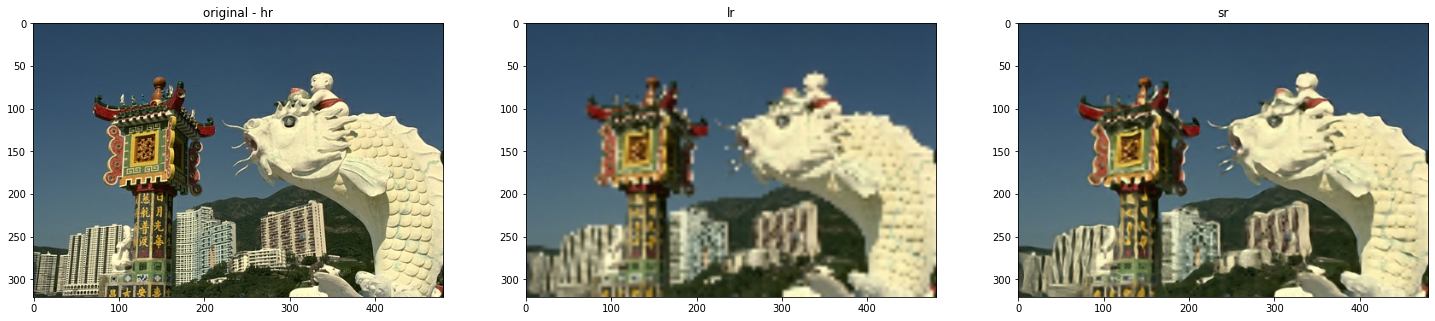

In [ ]:
plt.figure(figsize=(25,25))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

---
---

In [ ]:
model_s4 = tf.keras.models.load_model('/content/rednet-30-s4.h5', compile=False)

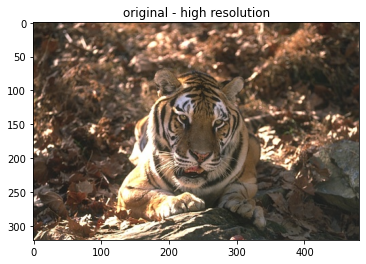

In [ ]:
# 테스트 데이터 이미지 출력
i = np.random.choice(100)
img = tf.io.read_file(test_path[i])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)
plt.title('original - high resolution')
plt.show()

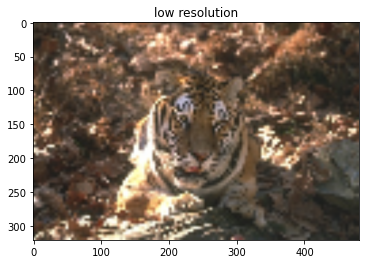

In [ ]:
# 이미지를 리사이징 하는 과정입니다. 
# 기존 이미지를 1/4로 줄이는 과정입니다. 
lr = tf.image.resize(hr, [hr.shape[0]//4, hr.shape[1]//4])
# 절반으로 줄어든 이미지를 다시 원본크기로 키워주겠습니다. 
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])

plt.imshow(lr)
plt.title('low resolution')
plt.show()

In [ ]:
# 배치 차원을 추가하여 예측을 수행하여 줍니다. 
predict_hr = model_s4.predict(np.expand_dims(lr, axis=0))

# 예측 사진과 실제 사진과의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))

# 낮은 해상도의 사진, 실제 해상도의 사진 사이의 psnr을 구하는 과정입니다. 
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(22.300848, shape=(), dtype=float32)
tf.Tensor(21.788614, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


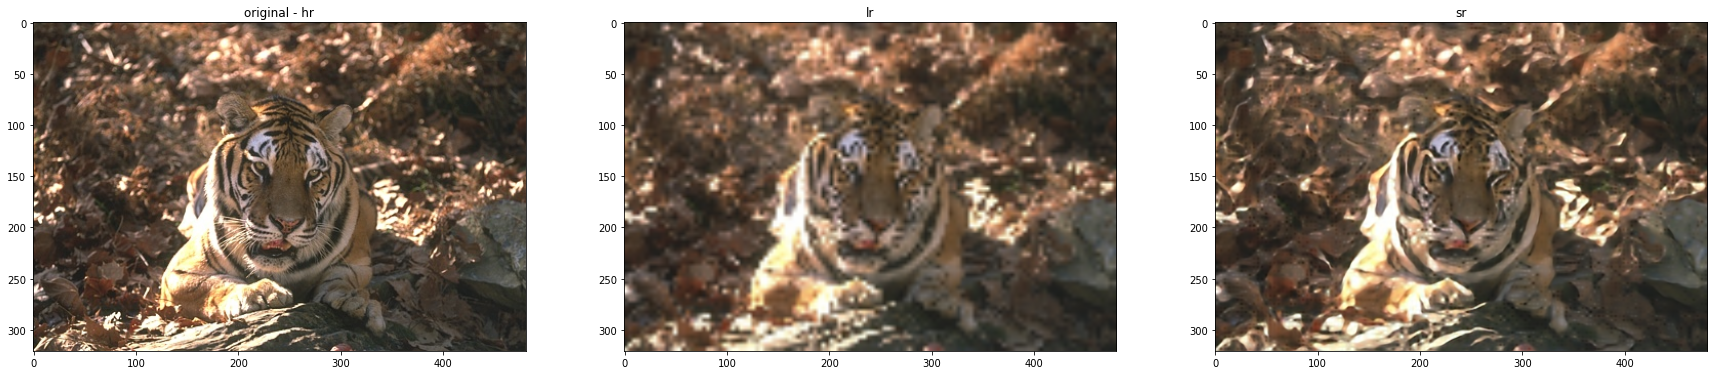

In [ ]:
plt.figure(figsize=(30,30))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

plt.show()